In [74]:
# For EDA
from collections import Counter
import matplotlib.pyplot as plt

# For Evaluation
import numpy as np
import pandas as pd

from wordcloud import WordCloud, STOPWORDS

from sentence_transformers import SentenceTransformer

## load_data

In [2]:
misclassified_df = pd.read_csv("misclass_df.csv",index_col=0)
misclassified_df 

,text,label,pred_label,label_mapping,pred_label_mapping
0,Can you freeze my card because someone used it...,22,16,compromised_card,card_payment_not_recognised
1,I made a transfer and am still waiting.,5,48,balance_not_updated_after_bank_transfer,pending_transfer
2,How do I know when my card will arrive?,11,12,card_arrival,card_delivery_estimate
3,Can I get my card expedited?,12,11,card_delivery_estimate,card_arrival
4,How long does it take for a transfer?,67,5,transfer_timing,balance_not_updated_after_bank_transfer
...,...,...,...,...,...
170,Can you help with a transfer to an account,7,65,beneficiary_not_allowed,transfer_into_account
171,How long does it take for an international tra...,5,67,balance_not_updated_after_bank_transfer,transfer_timing
172,My ATM got stuck and I'm not sure what to do.,18,26,card_swallowed,declined_cash_withdrawal
173,Is a copy of the police report necessary for c...,41,69,lost_or_stolen_card,verify_my_identity


## Embedding

In [3]:
model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True)

/home/dykos0508/.virtualenvs/nlp_311/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/dykos0508/.virtualenvs/nlp_311/lib/python3.11/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")
Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture 

In [91]:
query_prompt_name = "s2p_query"

def calculate_similarity(row):
    # Compute embeddings for label_mapping and text
    label_embedding = model.encode(row['label_mapping'], prompt_name=query_prompt_name)
    text_embedding = model.encode(row['text'], prompt_name=query_prompt_name)
    
    # Calculate similarity
    similarity = model.similarity(label_embedding, text_embedding)
    return similarity

# Apply the function to calculate similarity
misclassified_df['embed_label_sim'] = misclassified_df.apply(calculate_similarity, axis=1)

def calculate_similarity2(row):
    label_embedding = model.encode(row['pred_label_mapping'], prompt_name=query_prompt_name)
    text_embedding = model.encode(row['text'], prompt_name=query_prompt_name)
    
    similarity = model.similarity(label_embedding, text_embedding)
    return similarity

misclassified_df['embed_pred_label_sim'] = misclassified_df.apply(calculate_similarity2, axis=1)

# Identify doubtful cases where the similarity between predicted label and text is higher than the true label and text
misclassified_df['doubtful'] = misclassified_df['embed_label_sim'] < misclassified_df['embed_pred_label_sim']

def calculate_similarity3(row):
    label_embedding = model.encode(row['label_mapping'], prompt_name=query_prompt_name)
    text_embedding = model.encode(row['pred_label_mapping'], prompt_name=query_prompt_name)
    
    similarity = model.similarity(label_embedding, text_embedding)
    return similarity

misclassified_df['label_sim'] = misclassified_df.apply(calculate_similarity3, axis=1)


## Analysis

In [92]:
misclassified_df

,text,label,pred_label,label_mapping,pred_label_mapping,embed_label_sim,embed_pred_label_sim,doubtful,label_sim,label_set
0,Can you freeze my card because someone used it...,22,16,compromised_card,card_payment_not_recognised,[[tensor(0.5545)]],[[tensor(0.5015)]],False,[[tensor(0.5766)]],"{16, 22}"
1,I made a transfer and am still waiting.,5,48,balance_not_updated_after_bank_transfer,pending_transfer,[[tensor(0.6476)]],[[tensor(0.7810)]],True,[[tensor(0.6533)]],"{48, 5}"
2,How do I know when my card will arrive?,11,12,card_arrival,card_delivery_estimate,[[tensor(0.7875)]],[[tensor(0.7541)]],False,[[tensor(0.7630)]],"{11, 12}"
3,Can I get my card expedited?,12,11,card_delivery_estimate,card_arrival,[[tensor(0.6487)]],[[tensor(0.6067)]],False,[[tensor(0.7630)]],"{11, 12}"
4,How long does it take for a transfer?,67,5,transfer_timing,balance_not_updated_after_bank_transfer,[[tensor(0.7507)]],[[tensor(0.5482)]],False,[[tensor(0.5313)]],"{67, 5}"
...,...,...,...,...,...,...,...,...,...,...
170,Can you help with a transfer to an account,7,65,beneficiary_not_allowed,transfer_into_account,[[tensor(0.4141)]],[[tensor(0.8071)]],True,[[tensor(0.3914)]],"{65, 7}"
171,How long does it take for an international tra...,5,67,balance_not_updated_after_bank_transfer,transfer_timing,[[tensor(0.5819)]],[[tensor(0.5437)]],False,[[tensor(0.5313)]],"{67, 5}"
172,My ATM got stuck and I'm not sure what to do.,18,26,card_swallowed,declined_cash_withdrawal,[[tensor(0.4234)]],[[tensor(0.5472)]],True,[[tensor(0.4315)]],"{18, 26}"
173,Is a copy of the police report necessary for c...,41,69,lost_or_stolen_card,verify_my_identity,[[tensor(0.3514)]],[[tensor(0.3302)]],False,[[tensor(0.3614)]],"{41, 69}"


### label_counts

In [93]:
len(misclassified_df.label.value_counts())

60

In [94]:
print(misclassified_df.label.value_counts()[23])
print(misclassified_df.label.value_counts()[10])
print(misclassified_df.label.value_counts()[18])
print(misclassified_df.label.value_counts()[72])

1
5
2
2


In [95]:
misclassified_df.label.value_counts()[:10]

label
5     10
48     9
62     8
27     7
22     6
36     6
10     5
61     5
11     5
16     4
Name: count, dtype: int64

In [96]:
misclassified_df['pred_label'].value_counts()[:10]

pred_label
5     10
41     7
67     7
54     6
15     5
66     5
25     5
76     5
62     5
33     5
Name: count, dtype: int64

### label_pairs

In [97]:
misclassified_df['label_set'] = misclassified_df.apply(lambda row : set([row['label'],row['pred_label']]),axis=1)

In [98]:
misclassified_df['label_set'].value_counts()

label_set
{67, 5}     8
{11, 12}    7
{48, 5}     7
{16, 22}    4
{74, 69}    4
           ..
{41, 11}    1
{33, 50}    1
{74, 68}    1
{25, 59}    1
{61, 6}     1
Name: count, Length: 99, dtype: int64

In [121]:
misclassified_df.loc[misclassified_df['label'].isin([5,67])]

,text,label,pred_label,label_mapping,pred_label_mapping,embed_label_sim,embed_pred_label_sim,doubtful,label_sim,label_set
1,I made a transfer and am still waiting.,5,48,balance_not_updated_after_bank_transfer,pending_transfer,[[tensor(0.6476)]],[[tensor(0.7810)]],True,[[tensor(0.6533)]],"{48, 5}"
4,How long does it take for a transfer?,67,5,transfer_timing,balance_not_updated_after_bank_transfer,[[tensor(0.7507)]],[[tensor(0.5482)]],False,[[tensor(0.5313)]],"{67, 5}"
36,How long until my transfer will be available t...,5,67,balance_not_updated_after_bank_transfer,transfer_timing,[[tensor(0.5640)]],[[tensor(0.6670)]],True,[[tensor(0.5313)]],"{67, 5}"
52,How long is it going to take for my funds to s...,67,46,transfer_timing,pending_cash_withdrawal,[[tensor(0.4460)]],[[tensor(0.5613)]],True,[[tensor(0.3745)]],"{67, 46}"
60,My transfer is pending.,5,48,balance_not_updated_after_bank_transfer,pending_transfer,[[tensor(0.6044)]],[[tensor(0.9150)]],True,[[tensor(0.6533)]],"{48, 5}"
66,I didn't get the money I transferred,5,64,balance_not_updated_after_bank_transfer,transfer_fee_charged,[[tensor(0.6942)]],[[tensor(0.5462)]],False,[[tensor(0.4986)]],"{64, 5}"
74,When will my transfer be available in my account.,5,67,balance_not_updated_after_bank_transfer,transfer_timing,[[tensor(0.6671)]],[[tensor(0.6315)]],False,[[tensor(0.5313)]],"{67, 5}"
78,how long dies it take for transfers to reflect...,67,5,transfer_timing,balance_not_updated_after_bank_transfer,[[tensor(0.6125)]],[[tensor(0.7205)]],True,[[tensor(0.5313)]],"{67, 5}"
84,Where is my transfer from [country]?,5,67,balance_not_updated_after_bank_transfer,transfer_timing,[[tensor(0.5930)]],[[tensor(0.5954)]],True,[[tensor(0.5313)]],"{67, 5}"
93,I made an out of country transfer and it hasn'...,5,66,balance_not_updated_after_bank_transfer,transfer_not_received_by_recipient,[[tensor(0.6785)]],[[tensor(0.7004)]],True,[[tensor(0.7029)]],"{66, 5}"


### error_data

In [102]:
for _, row in misclassified_df.loc[misclassified_df['label'].isin([5])].iterrows():
    print(f"Text: {row['text']}")
    print(f"True Label: {row['label_mapping']}")
    print(f"Predicted Label: {row['pred_label_mapping']}")
    print('---')  # 分隔線

Text: I made a transfer and am still waiting.
True Label: balance_not_updated_after_bank_transfer
Predicted Label: pending_transfer
---
Text: How long until my transfer will be available to me
True Label: balance_not_updated_after_bank_transfer
Predicted Label: transfer_timing
---
Text: My transfer is pending.
True Label: balance_not_updated_after_bank_transfer
Predicted Label: pending_transfer
---
Text: I didn't get the money I transferred
True Label: balance_not_updated_after_bank_transfer
Predicted Label: transfer_fee_charged
---
Text: When will my transfer be available in my account.
True Label: balance_not_updated_after_bank_transfer
Predicted Label: transfer_timing
---
Text: Where is my transfer from [country]?
True Label: balance_not_updated_after_bank_transfer
Predicted Label: transfer_timing
---
Text: I made an out of country transfer and it hasn't went through yet.
True Label: balance_not_updated_after_bank_transfer
Predicted Label: transfer_not_received_by_recipient
---
Text

In [105]:
misclassified_df['doubtful'].value_counts()

doubtful
True     101
False     74
Name: count, dtype: int64

In [106]:
101 / 175

0.5771428571428572

In [132]:
# 首先過濾出 label_sim 大於 0.8 的數據
filtered_df = misclassified_df[misclassified_df['label_sim'] > 0.75]
print(len(filtered_df.label_set.value_counts()))
len(filtered_df.label_set.value_counts()) / len(misclassified_df.label_set.value_counts()) 

16


0.16161616161616163

In [145]:
misclassified_df.loc[misclassified_df['doubtful']==False,['label_mapping']].value_counts()

label_mapping                                   
balance_not_updated_after_bank_transfer             5
pending_transfer                                    5
fiat_currency_support                               5
verify_my_identity                                  4
topping_up_by_card                                  4
card_delivery_estimate                              3
balance_not_updated_after_cheque_or_cash_deposit    3
declined_card_payment                               3
extra_charge_on_statement                           2
transfer_timing                                     2
transfer_not_received_by_recipient                  2
pin_blocked                                         2
failed_transfer                                     2
wrong_exchange_rate_for_cash_withdrawal             2
card_acceptance                                     2
card_arrival                                        2
card_payment_not_recognised                         2
exchange_charge                  

# 基本畫圖

In [73]:
def plot_word_cloud(dataset_):
    
    all_text = " ".join([example for example in dataset_['text']])
    
    custom_stopwords = set(STOPWORDS)

    wordcloud = WordCloud(width=800, height=600, background_color='white', stopwords=custom_stopwords).generate(all_text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


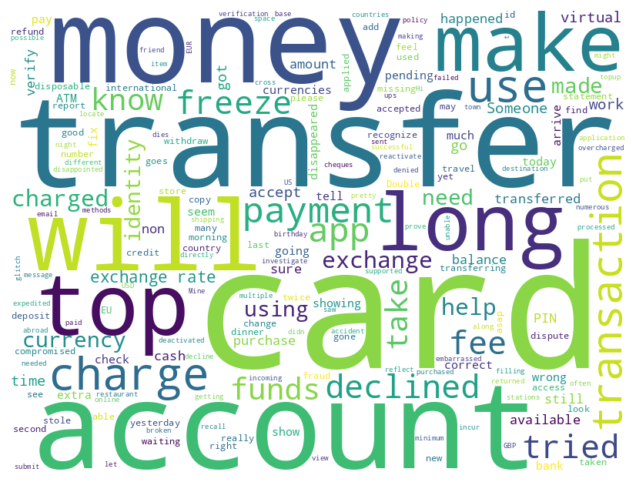

In [38]:
plot_word_cloud(misclassified_df)

In [69]:
plt.style.use('seaborn-v0_8')

def plot_misclassified_label_distribution(mis_df):
    # 提取標籤
    mis_labels = mis_df['label'].tolist()

    # 統計標籤的頻次
    mis_label_counts = Counter(mis_labels)

    plt.figure(figsize=(8, 5))
    plt.bar(mis_label_counts.keys(), mis_label_counts.values(), width=0.5, color='#77DD77')

    plt.xlabel("Label", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title("Misclassified Label Distribution", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
def show_misclassified_text_length(mis_df):
    # 計算文本的長度
    mis_text_lengths = [len(text.split()) for text in mis_df['text']]

    # 計算長度的平均值和中位數
    mis_mean = np.mean(mis_text_lengths)
    mis_median = np.median(mis_text_lengths)
    
    plt.figure(figsize=(8, 5))
    plt.hist(mis_text_lengths, bins=50, alpha=0.7, label=f'Misclassified (mean={mis_mean:.2f}, median={mis_median})', color='#77DD77')

    plt.legend(fontsize=14)
    plt.title("Misclassified Text Length Distribution", fontsize=16)
    plt.xlabel("Text Length", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

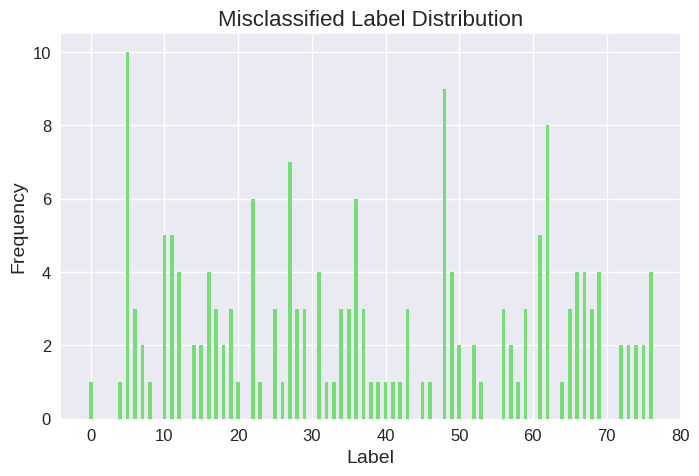

In [70]:
plot_misclassified_label_distribution(misclassified_df)

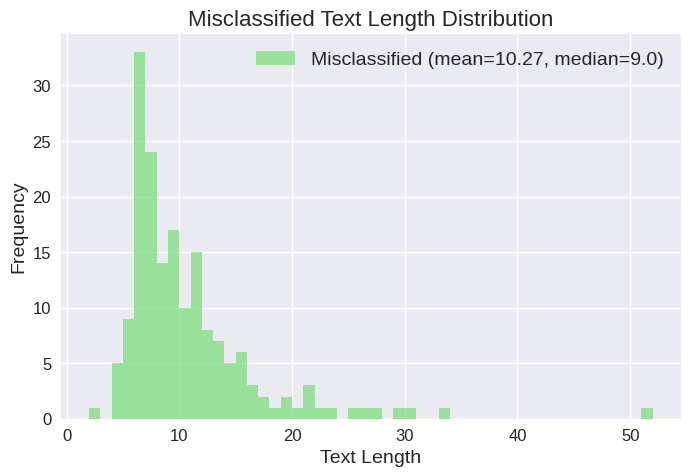

In [71]:
show_misclassified_text_length(misclassified_df)